In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/Users/ali.septiandri/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# AII

In [2]:
keywords = [
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'reinforcement learning',
    'neural network',
    # 'image recognition',
    'computer vision',
    'natural language processing',
    # 'model training',
    # 'inference',
    # 'hyperparameter',
    'speech processing',
    'control methods',
    'knowledge representation',
    'planning',
    'predictive analytics',
    'robotics',
]

In [3]:
patents = pd.read_csv('datasets/ai_patents.csv').drop('index', axis=1)
patents['year'] = patents['publication_date'].astype(str).str[:4].astype(int)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(lowercase=True, ngram_range=(1, 3), vocabulary=keywords, binary=True)
# X = vec.fit_transform(patents[patents['year'].ge(2015) & patents['year'].le(2020)].abstract.values)
X = vec.fit_transform(patents.abstract.values)

In [5]:
total = pd.DataFrame({
    'keywords': keywords,
    'freq': np.array(X.sum(axis=0)).flatten()
})
print(
    total.set_index('keywords')
    .style.to_latex()
)

\begin{tabular}{lr}
 & freq \\
keywords &  \\
machine learning & 10904 \\
deep learning & 1848 \\
artificial intelligence & 2674 \\
reinforcement learning & 506 \\
neural network & 9364 \\
computer vision & 463 \\
natural language processing & 917 \\
speech processing & 126 \\
control methods & 29 \\
knowledge representation & 24 \\
planning & 1050 \\
predictive analytics & 69 \\
robotics & 64 \\
\end{tabular}



In [6]:
(X.sum(axis=1) != 0).sum(axis=0)

matrix([[25283]])

In [7]:
patent_mask = (np.array(X.sum(axis=1)) != 0).flatten()
patents = patents[patent_mask].reset_index(drop=True).copy()

In [8]:
abstract_embeddings = np.load('datasets/abstract_embeddings_t5-xl.npy')
abstract_embeddings = abstract_embeddings[patent_mask].copy()

In [9]:
assert patents.shape[0] == abstract_embeddings.shape[0]

In [10]:
cai = pd.read_excel('datasets/Alphabetical-Index-of-Occupations-December-2019_Final.xlsx', skiprows=6)
# cai_embeddings = model.encode(cai['Description'].values)
# np.save('datasets/cai_embeddings.npy', cai_embeddings)
cai_embeddings = np.load('datasets/cai_embeddings.npy')

/Users/ali.septiandri/miniforge3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [11]:
similarity = cosine_similarity(
    cai_embeddings,
    abstract_embeddings[patents[patents['year'].ge(2015) & patents['year'].le(2022)].index]
)

In [12]:
cai['similarity'] = similarity.max(axis=1)
cai['s'] = cai['similarity'].gt(cai['similarity'].quantile(.90))

In [13]:
augmentation = cai.groupby('2018 SOC Code').agg({
    's': 'mean'
}).reset_index()

In [14]:
automation = pd.read_csv('datasets/2022/aii.csv')

In [15]:
aa = pd.merge(
    automation,
    augmentation,
    how='inner',
    left_on='SOC Code',
    right_on='2018 SOC Code'
)

In [16]:
aa['aii_p'] = pd.cut(aa['aii'], bins=100).cat.codes
aa['aug_p'] = pd.cut(aa['s'], bins=100).cat.codes

In [17]:
selected_occupations = {
    "Word Processors and Typists": "Typists",
    "Machinists": "Machinists",
    "Power Plant Operators": "Power Plant Operators",
    # "Sales Engineers": "Sales Engineers",
    "Hotel, Motel, and Resort Desk Clerks": "Hotel Clerks",
    "Radiologic Technologists and Technicians": "Radiologic Technologists",
    # "Hearing Aid Specialists": "Hearing Aid Specialists",
    "Electromechanical Equipment Assemblers": "Electromechanical Equipment Assemblers",
    "Cardiovascular Technologists and Technicians": "Cardiovascular Technologists",
    "Public Safety Telecommunicators": "Public Safety Telecommunicators",
    "Transportation Inspectors": "Transportation Inspectors",
    "Mechanical Engineers": "Mechanical Engineers",
    "Athletic Trainers": "Athletic Trainers",
    "Sound Engineering Technicians": "Sound Engineering Technicians",
    "Diagnostic Medical Sonographers": "Diagnostic Medical Sonographers",
    "Administrative Services Managers": "Administrative Services Managers",
}

In [18]:
aa[aa['Title'].isin(selected_occupations.keys())]

,SOC Code,nb_impacted_tasks,total_tasks,Title,aii,aioe,2018 SOC Code,s,aii_p,aug_p
16,51-8013,8,61,Power Plant Operators,0.131148,-0.348278,51-8013,0.000000,20,0
68,29-2034,8,27,Radiologic Technologists and Technicians,0.296296,-0.555904,29-2034,0.647059,46,64
79,43-4081,0,20,"Hotel, Motel, and Resort Desk Clerks",0.000000,0.606313,43-4081,0.000000,0,0
93,17-2141,18,79,Mechanical Engineers,0.227848,1.004709,17-2141,0.357143,35,35
106,29-2032,6,20,Diagnostic Medical Sonographers,0.300000,-0.264054,29-2032,0.812500,46,81
148,29-2031,16,25,Cardiovascular Technologists and Technicians,0.640000,-0.090953,29-2031,0.904762,99,90
181,29-9091,1,23,Athletic Trainers,0.043478,-0.331136,29-9091,0.250000,6,24
211,53-6051,4,54,Transportation Inspectors,0.074074,-0.183760,53-6051,0.528571,11,52
238,43-5031,8,18,Public Safety Telecommunicators,0.444444,0.907445,43-5031,0.416667,69,41
462,43-9022,4,20,Word Processors and Typists,0.200000,0.621961,43-9022,0.100000,31,9


In [19]:
aa[
    aa['aii_p'].gt(0) & aa['aii_p'].lt(50)
    & aa['aug_p'].gt(40) & aa['aug_p'].lt(100)
].sort_values('SOC Code')

,SOC Code,nb_impacted_tasks,total_tasks,Title,aii,aioe,2018 SOC Code,s,aii_p,aug_p
142,15-1212,1,12,Information Security Analysts,0.083333,NaN,15-1212,0.500000,13,49
644,15-1253,6,27,Software Quality Assurance Analysts and Testers,0.222222,NaN,15-1253,0.444444,34,44
90,17-1021,4,14,Cartographers and Photogrammetrists,0.285714,0.816998,17-1021,0.666667,44,66
64,17-2161,3,20,Nuclear Engineers,0.150000,1.303009,17-2161,0.444444,23,44
553,17-3012,5,27,Electrical and Electronics Drafters,0.185185,0.910166,17-3012,0.625000,28,62
512,19-4013,3,15,Food Science Technicians,0.200000,NaN,19-4013,0.666667,31,66
427,19-4051,5,38,Nuclear Technicians,0.131579,0.169674,19-4051,0.500000,20,49
308,27-3091,4,17,Interpreters and Translators,0.235294,1.111319,27-3091,0.500000,36,49
36,27-3092,2,14,Court Reporters and Simultaneous Captioners,0.142857,NaN,27-3092,0.500000,22,49
136,29-1024,2,11,Prosthodontists,0.181818,-0.156140,29-1024,0.666667,28,66


In [20]:
# aa.sort_values('SOC Code')[['SOC Code', 'Title', 'aii', 's', 'aii_p', 'aug_p']].rename({'s': 'aug'}, axis=1).to_csv('datasets/2022/auto_augment.csv', index=False)

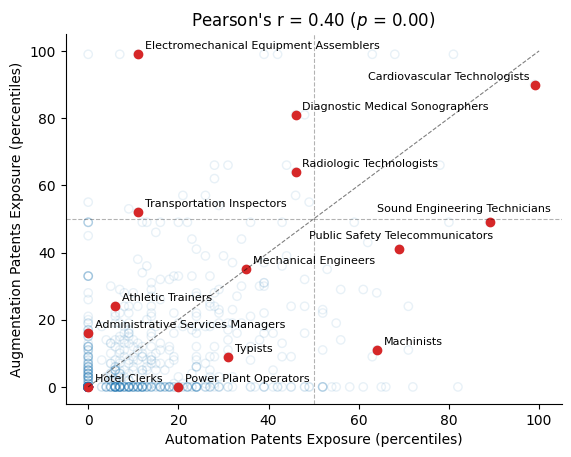

In [21]:
from scipy.stats import pearsonr

rho, pval = pearsonr(aa['aii'], aa['s'])

plt.scatter(
    x='aii_p',
    y='aug_p',
    data=aa,
    facecolor='none',
    edgecolor='C0',
    alpha=.1
)
plt.scatter(
    x='aii_p',
    y='aug_p',
    data=aa[aa['Title'].isin(selected_occupations.keys())],
    c='C3'
)
for occ in selected_occupations.keys():
    occ_data = aa[aa['Title'].eq(occ)].iloc[0]
    if selected_occupations[occ_data['Title']] == 'Cardiovascular Technologists':
        xy = (occ_data['aii_p'] - 37, occ_data['aug_p'] + 1.5)
    elif selected_occupations[occ_data['Title']] == 'Sound Engineering Technicians':
        xy = (occ_data['aii_p'] - 25, occ_data['aug_p'] + 3)
    elif selected_occupations[occ_data['Title']] == 'Public Safety Telecommunicators':
        xy = (occ_data['aii_p'] - 20, occ_data['aug_p'] + 3)
    else:
        xy = (occ_data['aii_p'] + 1.5, occ_data['aug_p'] + 1.5)

    plt.annotate(
        selected_occupations[occ_data['Title']],
        xy,
        fontsize=8,
    )
plt.plot([0, 100], [0, 100], linestyle='--', c='k', linewidth=0.8, alpha=.5)
plt.xlabel('Automation Patents Exposure (percentiles)')
plt.ylabel('Augmentation Patents Exposure (percentiles)')
plt.axhline(50, linestyle='--', linewidth=.8, c='k', alpha=.3)
plt.axvline(50, linestyle='--', linewidth=.8, c='k', alpha=.3)
plt.title(f"Pearson's r = {rho:.2f} ($p$ = {pval:.2f})")
sns.despine()
# plt.savefig('figures/2022/auto_aug_micro_titles_quad.pdf', bbox_inches='tight')

In [26]:
task_ratings = pd.read_csv('datasets/db_26_3_text/Task Ratings.txt', sep='\t').query('`Scale ID` == "IM"')
task_statements = pd.read_csv('datasets/db_26_3_text/Task Statements.txt', sep='\t')
jobs = pd.read_csv('datasets/db_26_3_text/Occupation Data.txt', sep='\t')
jobs['SOC Code'] = jobs['O*NET-SOC Code'].str[:7]

In [27]:
tasks = pd.merge(
    task_ratings,
    task_statements[['O*NET-SOC Code', 'Task ID', 'Task']],
    how='left',
    on=['O*NET-SOC Code', 'Task ID']
)

In [28]:
tasks.shape

(17879, 13)

In [29]:
# task_embeddings = model.encode(tasks['Task'].values)
# np.save('datasets/task_embeddings_t5.npy', task_embeddings)
task_embeddings = np.load('datasets/task_embeddings_26_3.npy')

In [30]:
similarity = cosine_similarity(
    task_embeddings,
    abstract_embeddings[patents[patents['year'].ge(2015) & patents['year'].le(2022)].index]
)

In [31]:
print(f"Tasks: {similarity.shape[0]:,.0f}")
print(f"Patents: {similarity.shape[1]:,.0f}")

Tasks: 17,879
Patents: 24,758


In [32]:
p_threshold = .90

tasks['similarity'] = similarity.max(axis=1)
tasks['patent_index'] = similarity.argmax(axis=1)
# tasks['weight'] = tasks['Data Value'] / tasks.groupby('O*NET-SOC Code')['Data Value'].transform('sum')
tasks['similarity_t'] = tasks['similarity'] * (tasks['similarity'] > tasks['similarity'].quantile(p_threshold)).astype(int)
tasks['s'] = tasks['similarity'].gt(tasks['similarity'].quantile(p_threshold))
# tasks['aii'] = tasks['similarity'] * tasks['weight']

In [33]:
print(f"Similarity threshold: {tasks['similarity'].quantile(p_threshold):.2f}")

Similarity threshold: 0.80


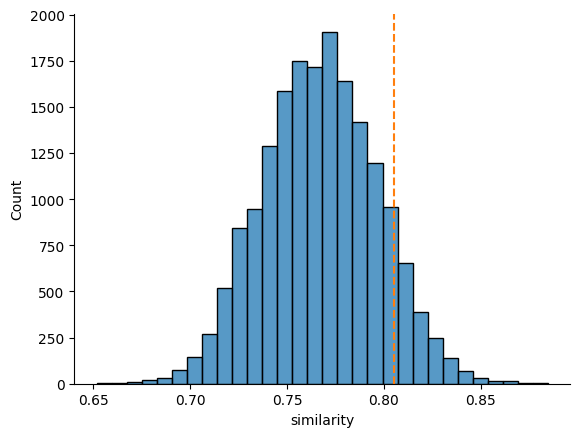

In [34]:
sns.histplot(x=tasks['similarity'], bins=30)
plt.axvline(tasks['similarity'].quantile(p_threshold), linestyle='--', c='C1')
sns.despine()

In [35]:
jobs_aii = (
    pl.from_dataframe(tasks)
    .group_by('O*NET-SOC Code')
    .agg(
        pl.col('s').mean().alias('aii'),
        pl.col('s').sum().alias('nb_impacted_tasks'),
        pl.col('s').count().alias('total_tasks'),
    )
    
    .join(
        pl.from_dataframe(jobs),
        how='left',
        on='O*NET-SOC Code'
    )
    .to_pandas()
)

In [36]:
aioe = pd.read_excel('datasets/AIOE_DataAppendix.xlsx', sheet_name='Appendix A')

In [37]:
# Joining the data with AIOE for comparison
data = (
    pl.from_dataframe(jobs_aii)
    .group_by('SOC Code')
    .agg(
        pl.col('nb_impacted_tasks').sum(),
        pl.col('total_tasks').sum(),
        pl.col('nb_impacted_tasks').sum().truediv(pl.col('total_tasks').sum()).alias('aii')
    )
    .join(
        pl.from_dataframe(aioe),
        how='left',
        on='SOC Code'
    )
    .to_pandas()
).rename({'AIOE': 'aioe'}, axis=1)

In [38]:
from scipy.stats import beta

posterior = beta(1 + data['nb_impacted_tasks'], 1 + data['total_tasks'])
data['mu_aii'] = posterior.mean()
data['sigma_aii'] = posterior.std()

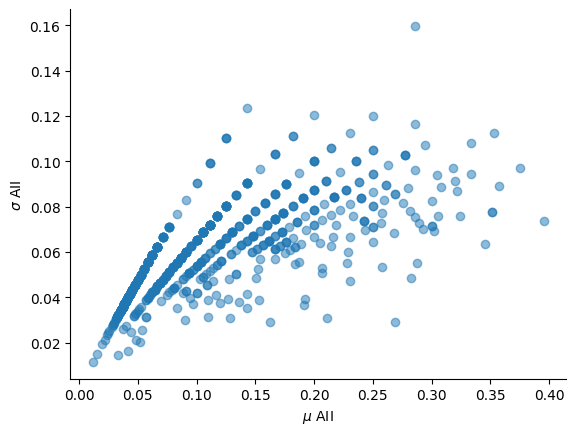

In [39]:
plt.scatter(
    x=data['mu_aii'],
    y=data['sigma_aii'],
    alpha=.5
)
plt.xlabel('$\mu$ AII')
plt.ylabel('$\sigma$ AII')
sns.despine()

In [40]:
tasks['SOC Code'] = tasks['O*NET-SOC Code'].str.slice(0, 7)
tasks['industry'] = tasks['O*NET-SOC Code'].str.slice(0, 2)

In [49]:
aii = tasks.groupby('SOC Code').agg({
    'similarity': ['mean', 'std'],
    'industry': 'max'
}).reset_index()

aii.columns = ['SOC Code', 'mu_aii', 'sigma_aii', 'industry']

In [69]:
selected_aii = pd.merge(
    aii,
    aa[aa['Title'].isin(selected_occupations.keys())][['SOC Code', 'Title']],
    how='inner',
    on='SOC Code'
)

In [77]:
selected_aii

,SOC Code,mu_aii,sigma_aii,industry,Title
0,11-3012,0.750174,0.026389,11,Administrative Services Managers
1,17-2141,0.787412,0.025477,17,Mechanical Engineers
2,27-4014,0.795261,0.036023,27,Sound Engineering Technicians
3,29-2031,0.812431,0.033054,29,Cardiovascular Technologists and Technicians
4,29-2032,0.789697,0.026124,29,Diagnostic Medical Sonographers
5,29-2034,0.789036,0.032516,29,Radiologic Technologists and Technicians
6,29-9091,0.758102,0.027401,29,Athletic Trainers
7,43-4081,0.751567,0.026824,43,"Hotel, Motel, and Resort Desk Clerks"
8,43-5031,0.795375,0.020680,43,Public Safety Telecommunicators
9,43-9022,0.776410,0.029993,43,Word Processors and Typists


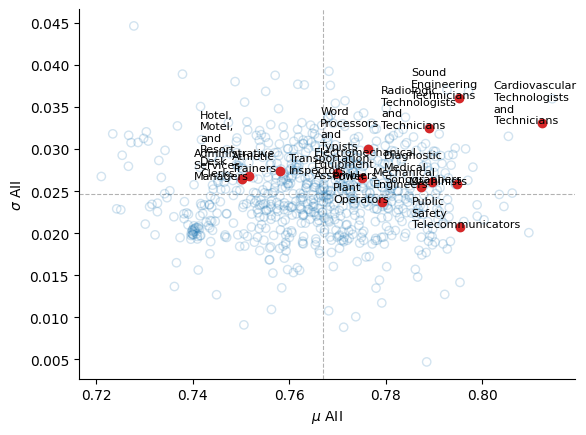

In [85]:
plt.scatter(
    x='mu_aii',
    y='sigma_aii',
    data=aii,
    facecolor='none',
    edgecolor='C0',
    alpha=.2
)
plt.scatter(
    x='mu_aii',
    y='sigma_aii',
    data=selected_aii,
    color='C3'
)
for _, occ_data in selected_aii.iterrows():
    # occ_data = aa[aa['Title'].eq(occ)].iloc[0]
    # if selected_occupations[occ_data['Title']] == 'Cardiovascular Technologists':
    #     xy = (occ_data['aii_p'] - 37, occ_data['aug_p'] + 1.5)
    # elif selected_occupations[occ_data['Title']] == 'Sound Engineering Technicians':
    #     xy = (occ_data['aii_p'] - 25, occ_data['aug_p'] + 3)
    # elif selected_occupations[occ_data['Title']] == 'Public Safety Telecommunicators':
    #     xy = (occ_data['aii_p'] - 20, occ_data['aug_p'] + 3)
    # else:
    xy = (occ_data['mu_aii'] - 0.01, occ_data['sigma_aii'])

    plt.annotate(
        occ_data['Title'].replace(' ', '\n'),
        xy,
        fontsize=8,
    )
plt.xlabel('$\mu$ AII')
plt.ylabel('$\sigma$ AII')
plt.axhline(aii['sigma_aii'].median(), linestyle='--', linewidth=.8, c='k', alpha=.3)
plt.axvline(aii['mu_aii'].median(), linestyle='--', linewidth=.8, c='k', alpha=.3)
sns.despine()
plt.savefig('figures/2022/auto_aug_avg_similarity.pdf', bbox_inches='tight')

In [242]:
occ_group_map = {
    11: 'Management',
    13: 'Business and Financial Operations',
    15: 'Computer and Mathematical',
    17: 'Architecture and Engineering',
    19: 'Life, Physical, and Social Science',
    21: 'Community and Social Service',
    23: 'Legal',
    25: 'Educational Instruction and Library',
    27: 'Arts, Design, Entertainment, Sports, and Media',
    29: 'Healthcare Practitioners and Technical',
    31: 'Healthcare Support',
    33: 'Protective Service',
    35: 'Food Preparation and Serving Related',
    37: 'Building and Grounds Cleaning and Maintenance',
    39: 'Personal Care and Service',
    41: 'Sales and Related',
    43: 'Office and Administrative Support',
    45: 'Farming, Fishing, and Forestry',
    47: 'Construction and Extraction',
    49: 'Installation, Maintenance, and Repair',
    51: 'Production',
    53: 'Transportation and Material Moving',
}

In [243]:
z = aii.groupby('industry').agg({
    'mu_aii': ['mean', 'std'],
    'sigma_aii': ['mean', 'std'],
})

z.columns = ['m_mu_aii', 's_mu_aii', 'm_sigma_aii', 's_sigma_aii']

In [244]:
z['occ_group'] = z.reset_index().industry.astype(int).map(occ_group_map).to_list()

In [318]:
selected_groups = [
    'Computer and Mathematical',
    'Healthcare Practitioners and Technical',
    'Architecture and Engineering',
    'Transportation and Material Moving',
    'Educational Instruction and Library',
    # 'Food Preparation and Serving Related',
    'Construction and Extraction',
    # 'Sales and Related',
    'Installation, Maintenance, and Repair',
    'Personal Care and Service',
    'Management',
    'Production',
    'Legal',
]

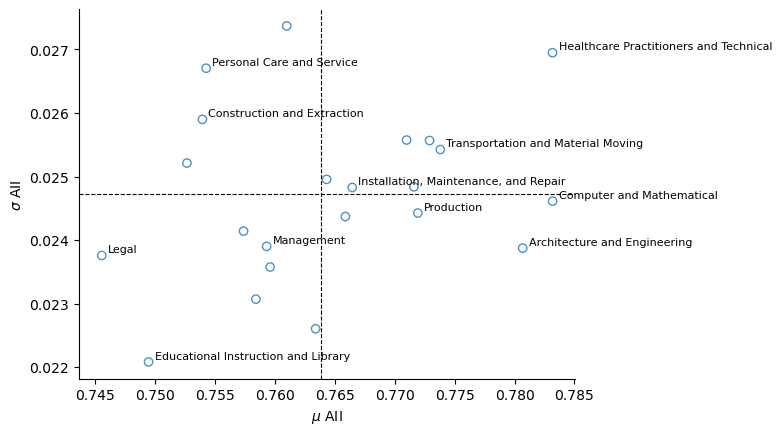

In [358]:
plt.scatter(
    x=z['m_mu_aii'],
    y=z['m_sigma_aii'],
    # xerr=z['s_mu_aii'],
    # yerr=z['s_sigma_aii'],
    # marker='o',
    # linestyle='none',
    # alpha=.7,
    facecolor='none',
    edgecolor='C0',
    alpha=.8
)
for _, row in z[z['occ_group'].isin(selected_groups)].iterrows():
    plt.annotate(
        row['occ_group'],
        (row['m_mu_aii'] + 5e-4, row['m_sigma_aii'] + 5e-5),
        fontsize=8,
    )
plt.axhline(z['m_sigma_aii'].median(), linestyle='--', c='k', linewidth=.8)
plt.axvline(z['m_mu_aii'].median(), linestyle='--', c='k', linewidth=.8)
plt.xlabel('$\mu$ AII')
plt.ylabel('$\sigma$ AII')
sns.despine()
plt.savefig('figures/2022/auto_aug_avg_similarity_group.pdf', bbox_inches='tight')

In [45]:
# Top-left
z[z['m_mu_aii'].lt(z['m_mu_aii'].median()) & z['m_sigma_aii'].gt(z['m_sigma_aii'].median())]['occ_group'].to_list()

['Protective Service',
 'Food Preparation and Serving Related',
 'Personal Care and Service',
 'Construction and Extraction']

In [46]:
# Bottom-right
z[z['m_mu_aii'].gt(z['m_mu_aii'].median()) & z['m_sigma_aii'].lt(z['m_sigma_aii'].median())]['occ_group'].to_list()

['Computer and Mathematical',
 'Architecture and Engineering',
 'Arts, Design, Entertainment, Sports, and Media',
 'Sales and Related']

In [297]:
aa['industry'] = aa['SOC Code'].str.slice(0, 2)
aa['occ_group'] = aa['industry'].astype(int).map(occ_group_map)

In [301]:
aag = (
    aa
    .groupby('occ_group')
    .agg({
        'aii': 'mean',
        's': 'mean'
    })
    .reset_index()
)

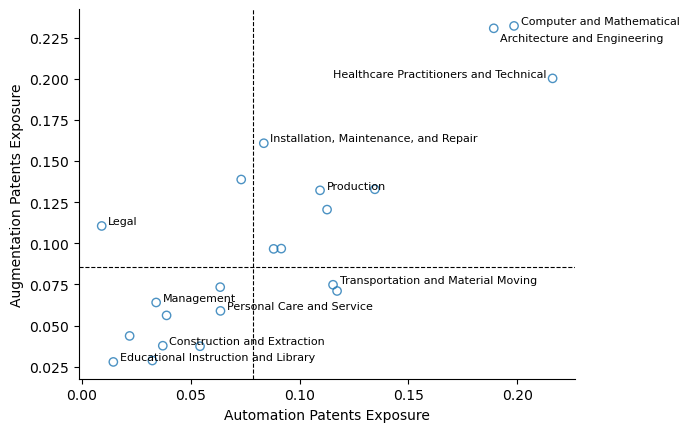

In [361]:
plt.scatter(
    x='aii',
    y='s',
    data=aag,
    facecolor='none',
    edgecolor='C0',
    alpha=.8
)
for _, row in aag[aag['occ_group'].isin(selected_groups)].iterrows():
    if row['occ_group'] == 'Architecture and Engineering':
        xy = (row['aii'] + 3e-3, row['s'] - 8e-3)
    elif row['occ_group'].startswith("Healthcare"):
        xy = (row['aii'] - 0.101, row['s'] + 1e-3)
    else:
        xy = (row['aii'] + 3e-3, row['s'] + 1e-3)
    
    plt.annotate(
        row['occ_group'],
        xy,
        fontsize=8,
    )
plt.axhline(aag['s'].median(), linestyle='--', c='k', linewidth=.8)
plt.axvline(aag['aii'].median(), linestyle='--', c='k', linewidth=.8)
# plt.plot([0, 100], [0, 100], linestyle='--', c='k', linewidth=0.8, alpha=.5)
plt.xlabel('Automation Patents Exposure')
plt.ylabel('Augmentation Patents Exposure')
sns.despine()
plt.savefig('figures/2022/auto_aug_micro_titles_group.pdf', bbox_inches='tight')

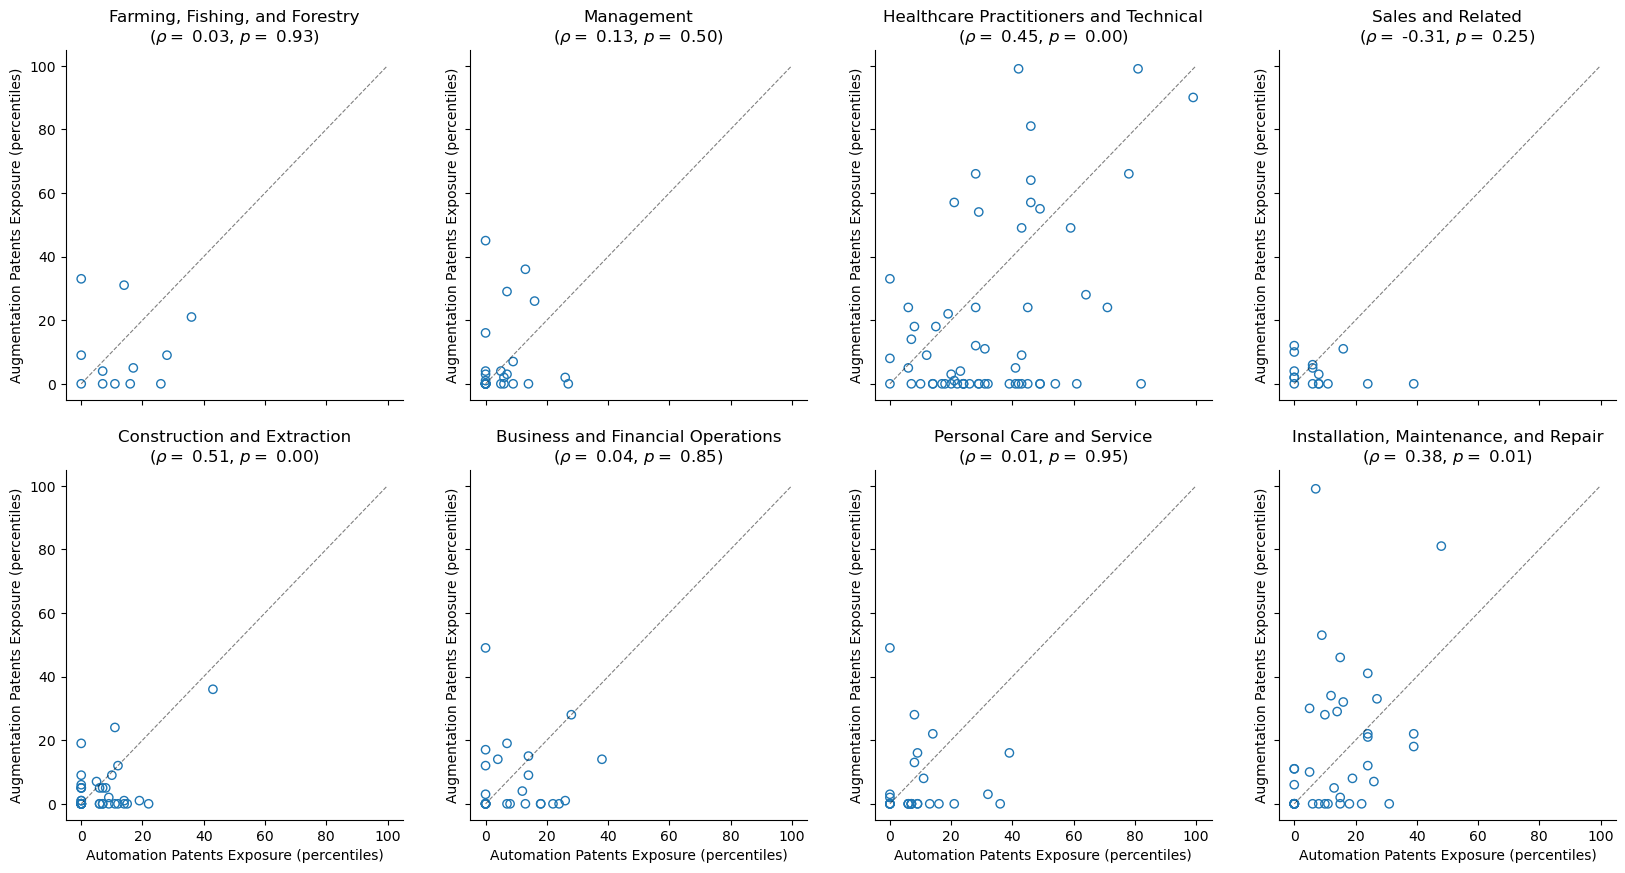

In [380]:
industries = [45, 47, 11, 13, 29, 39, 41, 49]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharex=True, sharey=True)
for ax, industry in zip(axes.T.flatten(), industries):
    data_aa = aa[aa['industry'].astype(int).eq(industry)]
    rho, pval = pearsonr(data_aa['aii'], data_aa['s'])

    ax.scatter(
        x='aii_p',
        y='aug_p',
        data=data_aa,
        facecolor='none',
        edgecolor='C0',
    )
    # ax.scatter(
    #     x='aii_p',
    #     y='aug_p',
    #     data=data_aa[data_aa['Title'].isin(selected_occupations.keys())],
    #     c='C3'
    # )
    # for occ in selected_occupations.keys():
    #     occ_data = aa[aa['Title'].eq(occ)].iloc[0]
    #     plt.annotate(
    #         selected_occupations[occ_data['Title']],
    #         (occ_data['aii_p'] + 1.5, occ_data['aug_p'] + 1.5),
    #         fontsize=8,
    #     )
    ax.plot([0, 100], [0, 100], linestyle='--', c='k', linewidth=0.8, alpha=.5)
    ax.set_title(f"{data_aa['occ_group'].iloc[0]}\n($\\rho =$ {rho:.2f}, $p =$ {pval:.2f})")
    ax.set_xlabel('')
    ax.set_ylabel('Augmentation Patents Exposure (percentiles)')

for i in range(4):
    axes[1][i].set_xlabel('Automation Patents Exposure (percentiles)')

sns.despine()
plt.savefig('figures/2022/auto_aug_per_group.pdf', bbox_inches='tight')